<center><font size=5>Homework 1: 构建两层神经网络分类器</font></center>

<center><font size=4>DATA620004 神经网络和深度学习</font></center>

<center><font size=4>22210980092 张亚楠</font></center>

<font size=4>github链接为：https://github.com/Janizhang/NN-task01/

**<font size=4>1、训练**

In [1]:
import numpy as np
# 导入需要的库

**<font size=3>定义激活函数以及所需要的导数**

In [2]:
def sigmoid(x):
    """Sigmoid 激活函数"""
    return 1 / (1 + np.exp(-x))

In [3]:
def sigmoid_derivative(x):
    """Sigmoid 函数的导数"""
    return sigmoid(x) * (1 - sigmoid(x))

In [4]:
def softmax(x):
    """Softmax 函数"""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

**<font size=3>反向传播，loss以及梯度的计算**

In [5]:
def initialize_parameters(input_size, hidden_size, output_size):
    """初始化模型参数"""
    W1 = np.random.randn(hidden_size, input_size) * 0.01
    b1 = np.zeros((hidden_size, 1))
    W2 = np.random.randn(output_size, hidden_size) * 0.01
    b2 = np.zeros((output_size, 1))
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

In [56]:
def forward_propagation(X, parameters):
    """前向传播"""
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # 第一层
    Z1 = np.dot(W1, X.T) + b1
    A1 = sigmoid(Z1)
    
    # 第二层
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2)
    #A2 = np.clip(A2, 1e-8, 1 - 1e-8)    #进行平滑操作，防止出现log0的情况
    
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    
    return A2, cache

In [48]:
def backward_propagation(X, Y, cache, parameters, lambd):
    """反向传播"""
    m = X.shape[0]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    # 计算输出层误差
    dZ2 = A2 - Y.T
    
    # 计算输出层权重和偏置的梯度
    dW2 = np.dot(dZ2, A1.T) / m # + lambd * W2 / m 这里有必要加正则化吗
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    
    # 计算隐藏层误差
    dZ1 = np.dot(W2.T, dZ2) * sigmoid_derivative(cache["Z1"])
    
    # 计算隐藏层权重和偏置的梯度
    dW1 = np.dot(dZ1, X) / m # + lambd * W1 / m  还有这里
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m
    
    gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    
    return gradients

**<font size=3>在损失计算函数中，加上$L_2$正则化**

In [65]:
def compute_loss(A2, Y, parameters, lambd):
    """计算损失"""
    n = Y.shape[0]
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    cross_entropy_loss = -np.sum(Y.T * np.log(A2)) / n
    L2_regularization = (np.sum(np.square(W1)) + np.sum(np.square(W2))) * lambd / (2*m)
    ## 计算L2正则化
    loss = cross_entropy_loss + L2_regularization
    
    return loss

In [9]:
def update_parameters(parameters, gradients, learning_rate):
    """更新模型参数"""
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    dW1 = gradients["dW1"]
    db1 = gradients["db1"]
    dW2 = gradients["dW2"]
    db2 = gradients["db2"]
    
    # 更新权重和偏置
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    np.savez("model.npz", **parameters) ## 将模型保存在“model.npz中”
    
    return parameters

**<font size=3>在下面定义的train函数中，我们将用到学习率下降策略和优化器SGD**

**<font size=3>（1）虽然采用学习率衰减的方法能让模型收敛的更好，但是如果遇到鞍点的时候，模型就没法继续收敛，如果学习率此时很小，那将永远无法走出鞍点；为了解决这一问题，我采用Cyclical Learning Rates(CRL)的方法，设置max_lr与base_lr这两个参数，让学习率在这两个数之间变化，且max_lr会随时间衰减，从而达到学习率下降的目的**

**<font size=3>（2）在优化器SGD中，我采用的是mini-batch方法，每次随机获取小批量数据，大小由batch_size来指定，利用这些数据进行梯度更新**

In [63]:
def train(X, Y, input_size, hidden_size, output_size, learning_rate, num_iterations, lambd, gamma):
    """训练模型"""
    parameters = initialize_parameters(input_size, hidden_size, output_size)
    lr = learning_rate
    max_lr = learning_rate
    base_lr = max_lr/4
    for i in range(num_iterations):
        # 获取mini-batch
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = X[batch_mask]
        y_batch = Y[batch_mask]
        
        A2, cache = forward_propagation(x_batch, parameters)
        #loss = compute_loss(A2, y_batch, parameters, lambd)
        gradients = backward_propagation(x_batch, y_batch, cache, parameters, lambd)
        parameters = update_parameters(parameters, gradients, lr)
        
        step_size = 100
        if i % step_size == 0:
            cycle = np.floor(1+i/(2*step_size))
            x = np.abs(i/step_size - 2*cycle + 1)
            lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))*gamma**(i/step_size)
            
        
    return parameters

**<font size=4>2、参数查找：学习率，隐藏层大小，正则化强度**

**<font size=3>定义网格搜索函数，在我们给出的包含多个学习率的列表learning_rates, 隐藏层大小列表hidden_sizes以及正则化强度列表lambdas中进行网格搜索，通过比较验证集的分类精度，选出最优的参数，最后输出最优参数及相应的分类精度**

In [11]:
def grid_search(X_train, Y_train, X_val, Y_val, input_size, output_size, learning_rates, hidden_sizes, lambdas, num_iterations):
    """网格搜索参数"""
    best_accuracy = -1
    best_params = {}
    for lr in learning_rates:
        for hs in hidden_sizes:
                for ld in lambdas:
                    print(f"学习率: {lr}，隐藏层大小: {hs}，正则化强度: {ld}")
                    parameters = train(X_train, Y_train, input_size, hs, output_size, lr, num_iterations, ld, gamma)
                    accuracy = test(X_val, Y_val, parameters)
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        r, h, d = lr, hs, ld
    best_params = {"learning_rate": r, "hidden_size": h, "lambda": d}
    print(f"最佳参数: {best_params}，分类精度: {best_accuracy}")
    return best_params

**<font size=4>3、测试：用经过参数查找后的模型进行测试，输出分类精度**

**<font size=3>predict函数用于在给定参数下做出预测；test函数输出给定模型下数据集的分类精度**

In [12]:
def predict(X, parameters):
    """模型预测"""
    A2, _ = forward_propagation(X, parameters)
    predictions = np.argmax(A2, axis=0)
    return predictions

In [13]:
def test(X, Y, parameters):
    """测试模型"""
    predictions = predict(X, parameters)
    accuracy = np.mean(predictions == np.argmax(Y.T, axis=0))
    print(f"分类精度: {accuracy}")
    return accuracy

**<font size=3>定义load_data()函数将mnist数据集导入，并分成三部分：训练集，验证集和测试集**

In [25]:
# 加载数据集
import gzip
import pickle
import numpy as np

def one_hot(y):
    """将类别向量转换为独热编码"""
    one_hot_y = np.zeros((y.shape[0], 10))
    for i in range(y.shape[0]):
        one_hot_y[i, y[i]] = 1
    return one_hot_y


def load_data():
    with gzip.open('./mnist.pkl.gz', 'rb') as f:
        train_data, val_data, test_data = pickle.load(f, encoding='latin1')
        X_train, Y_train = train_data[0], one_hot(train_data[1])
        X_val, Y_val = val_data[0], one_hot(val_data[1])
        X_test, Y_test = test_data[0], one_hot(test_data[1])
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [26]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_data()

**<font size=3>给出确定的超参数以及待搜索的超参数列表：学习率，隐藏层大小和正则化强度**

In [66]:
# 指定参数以及搜索范围
input_size = 784
output_size = 10
learning_rates = [0.01, 0.05, 0.1]
hidden_sizes = [50, 100, 200]
lambdas = [0.1, 0.2, 0.3]
num_iterations = 2000
train_size = X_train.shape[0]
batch_size = 100

**<font size=3>导入模型**

In [67]:
best_params = grid_search(X_train, Y_train, X_val, Y_val, input_size, output_size, learning_rates, hidden_sizes, lambdas, num_iterations)

学习率: 0.01，隐藏层大小: 50，正则化强度: 0.1
分类精度: 0.1064
学习率: 0.01，隐藏层大小: 50，正则化强度: 0.2
分类精度: 0.1064
学习率: 0.01，隐藏层大小: 50，正则化强度: 0.3
分类精度: 0.1064
学习率: 0.01，隐藏层大小: 100，正则化强度: 0.1
分类精度: 0.1064
学习率: 0.01，隐藏层大小: 100，正则化强度: 0.2
分类精度: 0.157
学习率: 0.01，隐藏层大小: 100，正则化强度: 0.3
分类精度: 0.1064
学习率: 0.01，隐藏层大小: 200，正则化强度: 0.1
分类精度: 0.164
学习率: 0.01，隐藏层大小: 200，正则化强度: 0.2
分类精度: 0.1851
学习率: 0.01，隐藏层大小: 200，正则化强度: 0.3
分类精度: 0.1937
学习率: 0.05，隐藏层大小: 50，正则化强度: 0.1
分类精度: 0.6781
学习率: 0.05，隐藏层大小: 50，正则化强度: 0.2
分类精度: 0.6764
学习率: 0.05，隐藏层大小: 50，正则化强度: 0.3
分类精度: 0.6614
学习率: 0.05，隐藏层大小: 100，正则化强度: 0.1
分类精度: 0.7493
学习率: 0.05，隐藏层大小: 100，正则化强度: 0.2
分类精度: 0.7394
学习率: 0.05，隐藏层大小: 100，正则化强度: 0.3
分类精度: 0.7326
学习率: 0.05，隐藏层大小: 200，正则化强度: 0.1
分类精度: 0.7952
学习率: 0.05，隐藏层大小: 200，正则化强度: 0.2
分类精度: 0.7842
学习率: 0.05，隐藏层大小: 200，正则化强度: 0.3
分类精度: 0.8033
学习率: 0.1，隐藏层大小: 50，正则化强度: 0.1
分类精度: 0.8581
学习率: 0.1，隐藏层大小: 50，正则化强度: 0.2
分类精度: 0.8482
学习率: 0.1，隐藏层大小: 50，正则化强度: 0.3
分类精度: 0.8475
学习率: 0.1，隐藏层大小: 100，正则化强度: 0.1
分类精度: 0.869
学习率: 0.1，隐藏层大小: 100，正则化强度:

**<font size=3>网格搜索的结果显示，学习率较小时的分类精度过低，而学习率较大时的分类精度却比较高，应该是学习率较小时迭代步数的限制使得它还没能找到最优点，于是定义train_pro函数对前面的方法进行改进：设置停止条件，当连续1000次验证集分类精度提升不到指定阈值时，停止迭代，这样可以减小不必要的计算；改进的grid_search_pro函数中，最大迭代次数随着学习率的下降而递增，以防出现学习率低时达不到最优点的情况**

In [42]:
# 迭代训练
def train_pro(X, Y, input_size, hidden_size, output_size, learning_rate, num_iterations, lambd, gamma):
    """训练模型"""
    parameters = initialize_parameters(input_size, hidden_size, output_size)
    lr = learning_rate
    max_lr = learning_rate
    base_lr = max_lr/4
    # 在训练过程中定义一个变量来记录最佳的验证集分类精度
    best_val_acc = 0.0

    # 定义一个变量来记录连续验证集分类精度不再提升的次数
    no_improvement_count = 0
    max_no_improvement = 1000
    # 定义一个阈值，用于判断验证集分类精度是否提升
    val_acc_threshold = 0.001

    for i in range(num_iterations):
        # 获取mini-batch
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = X[batch_mask]
        y_batch = Y[batch_mask]
        
        A2, cache = forward_propagation(x_batch, parameters)
        #loss = compute_loss(A2, y_batch, parameters, lambd)
        gradients = backward_propagation(x_batch, y_batch, cache, parameters, lambd)
        parameters = update_parameters(parameters, gradients, lr)
        
        step_size = 1000
        if i % step_size == 0:
            cycle = np.floor(1+i/(2*step_size))
            x = np.abs(i/step_size - 2*cycle + 1)
            lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))*gamma**(i/2000)
        
        predictions = predict(X_val, parameters)
        val_acc = np.mean(predictions == np.argmax(Y_val.T, axis=0))
        # 判断验证集分类精度是否提升
        if val_acc > best_val_acc + val_acc_threshold:
            best_val_acc = val_acc
            no_improvement_count = 0
        elif val_acc > 0.9:
            no_improvement_count += 1
        else:
            continue
        # 如果连续no_improvement_count次验证集分类精度未提升，则停止迭代
        if no_improvement_count >= max_no_improvement:
            # print("Validation accuracy did not improve for {} epochs. Stopping training.".format(no_improvement_count))
            break
    # print(f"分类精度: {val_acc}")
    return parameters, val_acc

In [43]:
def grid_search_pro(X_train, Y_train, X_val, Y_val, input_size, output_size, learning_rates, hidden_sizes, lambdas, num_iterations):
    """网格搜索参数"""
    best_accuracy = -1
    best_params = {}
    for lr in learning_rates:
        for hs in hidden_sizes:
                for ld in lambdas:
                    print(f"学习率: {lr}，隐藏层大小: {hs}，正则化强度: {ld}")
                    k = 0.002/lr
                    num_iterations += int(k*10000)
                    parameters, accuracy = train_pro(X_train, Y_train, input_size, hs, output_size, lr, num_iterations, ld, gamma)
                    print(f"分类精度: {accuracy}")
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        r, h, d = lr, hs, ld
    best_params = {"learning_rate": r, "hidden_size": h, "lambda": d}
    print(f"最佳参数: {best_params}，分类精度: {best_accuracy}")
    return best_params

**<font size=3>网格搜索找出最优参数，为model_params，训练得到最佳参数parameters，输出在测试集上的分类精度**

In [70]:
parameters = train(X_train, Y_train, input_size, best_params["hidden_size"], output_size, best_params["learning_rate"], num_iterations, best_params["lambda"],gamma)
test(X_test, Y_test, parameters)

分类精度: 0.8703


0.8703

**<font size=4>4、将参数查找后得到的最佳模型中每层网络参数可视化**

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
# 导入绘图的库

In [72]:
# 假设已经训练好了一个两层神经网络，权重保存在W1和W2中，偏置保存在b1和b2中

# 获取网络参数
W1 = parameters['W1']# 第一层权重
W2 = parameters['W2']# 第二层权重
b1 = parameters['b1']# 第一层偏置
b2 = parameters['b2']# 第二层偏置

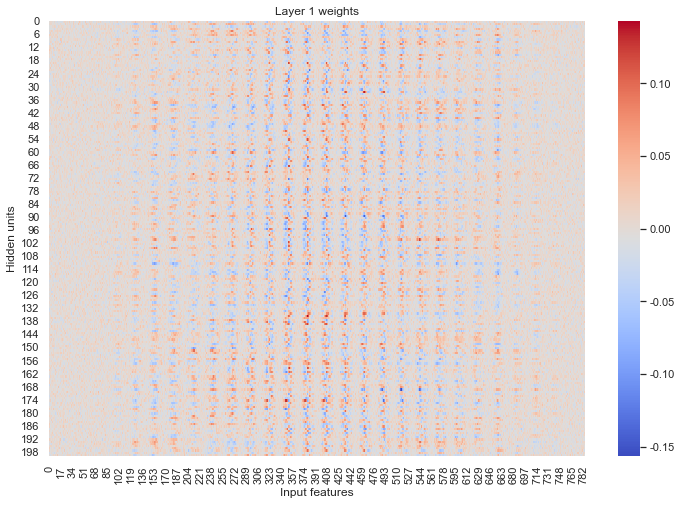

In [85]:
# 绘制权重热力图
# 可视化第一层权重
plt.figure(figsize=(12, 8))
sns.set()
sns.heatmap(W1, cmap="coolwarm")
plt.title("Layer 1 weights")
plt.xlabel("Input features")
plt.ylabel("Hidden units")
plt.show()

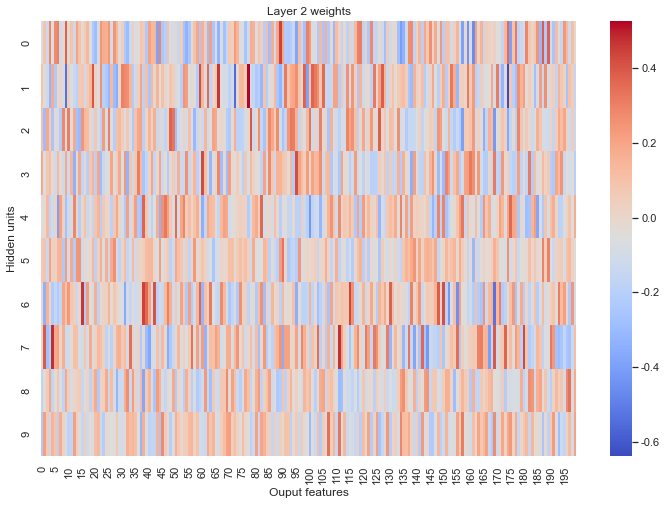

In [87]:
# 绘制权重热力图
# 可视化第二层偏置
plt.figure(figsize=(12, 8))
sns.set()
sns.heatmap(W2, cmap="coolwarm")
plt.title("Layer 2 weights")
plt.xlabel("Ouput features")
plt.ylabel("Hidden units")
plt.show()

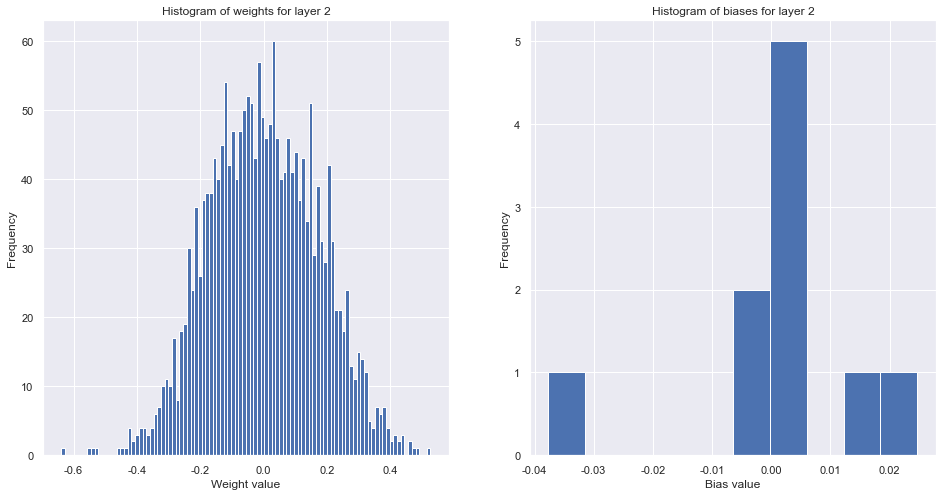

In [90]:
# 可视化第一层偏差
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.hist(W2.flatten(), bins=100)
plt.title("Histogram of weights for layer 2")
plt.xlabel("Weight value")
plt.ylabel("Frequency")

# 可视化第二层偏差
plt.subplot(122)
plt.hist(b2.flatten(), bins=10)
plt.title("Histogram of biases for layer 2")
plt.xlabel("Bias value")
plt.ylabel("Frequency")
plt.show()

**<font size=4>5、可视化训练和测试的loss曲线，测试的accuracy曲线**

In [101]:
def plot(best_params, X, Y):
    lr = best_params['learning_rate']
    max_lr = best_params['learning_rate']
    base_lr = max_lr/4
    step_size = 100
    hs = best_params['hidden_size']
    lm = best_params['lambda']
    acc = []
    acc_val = []
    acc_test = []
    loss_list = []
    loss_val =  []
    loss_test = []
    lr_list = []
    parameters = initialize_parameters(input_size, hs, output_size)
    for i in range(num_iterations):
        # 获取mini-batch
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = X[batch_mask]
        y_batch = Y[batch_mask]
        
        A2, cache = forward_propagation(x_batch, parameters)
        loss = compute_loss(A2, y_batch, parameters, lm)
        gradients = backward_propagation(x_batch, y_batch, cache, parameters, lm)
        parameters = update_parameters(parameters, gradients, lr)
        
        if i % step_size == 0:
            #lr *= gamma
            cycle = np.floor(1+i/(2*step_size))
            x = np.abs(i/step_size - 2*cycle + 1)
            lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))*gamma**(i/step_size)
            lr_list.append(lr)
            #print(f"迭代次数: {i}，损失: {loss}")
            
            predictions1 = predict(X_train, parameters)
            accuracy1 = np.mean(predictions1 == np.argmax(Y_train.T, axis=0))
            predictions2 = predict(X_val, parameters)
            accuracy2 = np.mean(predictions2 == np.argmax(Y_val.T, axis=0))
            predictions3 = predict(X_test, parameters)
            accuracy3 = np.mean(predictions3 == np.argmax(Y_test.T, axis=0))
            
            acc.append(accuracy1)
            acc_val.append(accuracy2)
            acc_test.append(accuracy3)
            
            A2_1, cache_1 = forward_propagation(X_train, parameters)
            loss1 = compute_loss(A2_1, Y_train, parameters, lm)
            loss_list.append(loss1)
            
            A2_2, cache = forward_propagation(X_val, parameters)
            loss2 = compute_loss(A2_2, Y_val, parameters, lm)
            loss_val.append(loss2)
            
            A2_3, cache_3 = forward_propagation(X_test, parameters)
            loss3 = compute_loss(A2_3, Y_test, parameters, lm)
            loss_test.append(loss3)
            
            print(f"学习率为{lr:.4f}时，训练集分类精度: {accuracy1}, 验证集分类精度:{accuracy2}")
            
        else:
            continue
        
    plt.figure()
     
    
    epochs = range(len(acc))
     
    plt.plot(epochs, acc, 'r', label='Training acc')         #训练集的accuracy
    plt.plot(epochs, acc_val, 'b', label='Validation acc')   #验证集的accuracy
    plt.plot(epochs, acc_test, 'g', label='Test acc')        #测试集的accuracy
    plt.title('Training and validation accuracy')
    plt.legend() # 绘制图例，默认在右上角
     
    plt.figure()
     
    plt.plot(epochs, loss_list, 'r', label='Training loss')   #训练集的loss
    plt.plot(epochs, loss_val, 'b', label='Validation loss')  #验证集的loss
    plt.plot(epochs, loss_test, 'g', label='Test loss')        #测试集的loss
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, lr_list, 'b', label='learning rate')     #学习率变化曲线
    plt.title('Learning rates')
    plt.show()

**<font size=3>调用plot函数，将训练和测试的loss曲线、测试的accuracy曲线可视化**

学习率为0.0250时，训练集分类精度: 0.09864, 验证集分类精度:0.0991
学习率为0.0925时，训练集分类精度: 0.09874, 验证集分类精度:0.0992
学习率为0.0250时，训练集分类精度: 0.19948, 验证集分类精度:0.1901
学习率为0.0797时，训练集分类精度: 0.378, 验证集分类精度:0.3934
学习率为0.0250时，训练集分类精度: 0.5172, 验证集分类精度:0.5392
学习率为0.0693时，训练集分类精度: 0.58694, 验证集分类精度:0.6002
学习率为0.0250时，训练集分类精度: 0.73796, 验证集分类精度:0.7621
学习率为0.0609时，训练集分类精度: 0.7267, 验证集分类精度:0.7535
学习率为0.0250时，训练集分类精度: 0.7387, 验证集分类精度:0.763
学习率为0.0541时，训练集分类精度: 0.78248, 验证集分类精度:0.8064
学习率为0.0250时，训练集分类精度: 0.80506, 验证集分类精度:0.8239
学习率为0.0485时，训练集分类精度: 0.81408, 验证集分类精度:0.8372
学习率为0.0250时，训练集分类精度: 0.82262, 验证集分类精度:0.8442
学习率为0.0441时，训练集分类精度: 0.82526, 验证集分类精度:0.847
学习率为0.0250时，训练集分类精度: 0.83368, 验证集分类精度:0.8515
学习率为0.0404时，训练集分类精度: 0.84394, 验证集分类精度:0.86
学习率为0.0250时，训练集分类精度: 0.84644, 验证集分类精度:0.8624
学习率为0.0375时，训练集分类精度: 0.85172, 验证集分类精度:0.8664
学习率为0.0250时，训练集分类精度: 0.85644, 验证集分类精度:0.8714
学习率为0.0351时，训练集分类精度: 0.8603, 验证集分类精度:0.876


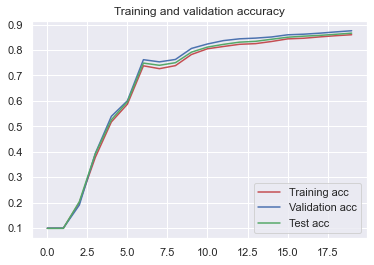

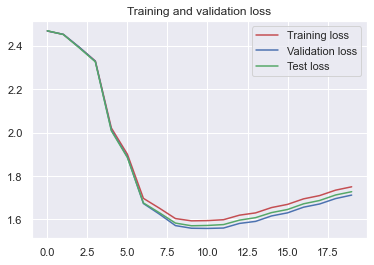

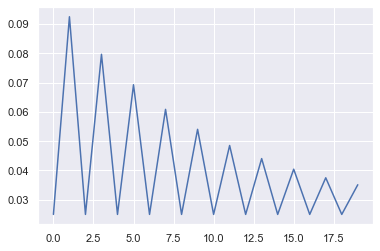

In [102]:
plot(best_params, X_train, Y_train)    